In [1]:
import pandas as pd
import random
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import TruncatedSVD
# from sklearn.preprocessing import normalize

# from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib

import pickle
import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro
%load_ext watermark

In [2]:
# old one '1.8.1+cu111'
torch.__version__

'2.1.1+cu121'

In [3]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop, train_loop_batches_eval
from text_embeddings_src.data_stuff import MultOverlappingSentencesPairDataset
from text_embeddings_src.metrics import knn_accuracy
from text_embeddings_src.embeddings import generate_embeddings

In [4]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
variables_path = Path("../../results/variables")
variables_pubmed_path = Path("../../../pubmed-landscape/results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [6]:
plt.style.use("../matplotlib_style.txt")

In [8]:
model = None
gc.collect()
torch.cuda.empty_cache()

In [8]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers -p openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2023-12-13 15:36:50CET

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

openTSNE: 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

pandas         : 2.1.3
sklearn        : 1.3.2
memory_profiler: 0.61.0
black          : 23.11.0
torch          : 2.1.1
scipy          : 1.11.4
matplotlib     : 3.8.2
jupyter_black  : 0.3.4
distro         : 1.8.0
numpy          : 1.26.2

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import

## ICLR

In [8]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 295 ms, sys: 95.2 ms, total: 390 ms
Wall time: 678 ms


In [9]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [68]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [11]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [12]:
# sanity check
print(len(np.unique(labels_iclr)))
labels_iclr

46


array(['unlabeled', 'unlabeled', 'optimization', ..., 'unlabeled',
       'unlabeled', 'federated learning'], dtype='<U34')

## PubMed

In [13]:
# Import
pubmed = pd.read_pickle(
    "/gpfs01/berens/data/data/pubmed_processed/df_labeled_papers_subset"
)
pubmed = pubmed.reset_index(drop=True)
pubmed_colors = pubmed["Colors"].to_numpy()

In [14]:
pubmed.head()

,PMID,Title,AbstractText,Language,Journal,Date,filename,Colors
0,18489772,Prevalence of bortezomib-resistant constitutiv...,The proteasome inhibitor bortezomib can inhibi...,eng,Molecular cancer,2008 May 19,pubmed21n0599.xml,black
1,25336168,Visualization of the entire differentiation pr...,The microfold (M) cell residing in the follicl...,eng,Mucosal immunology,2015 May,pubmed21n0810.xml,#8FB0FF
2,24705805,Incisional hernia in recipients of adult to ad...,After receiving a living donor liver transplan...,eng,World journal of surgery,2014 Aug,pubmed21n0790.xml,#006FA6
3,29315767,Benchmark dose analysis framework for developi...,The effects characterization phase of ecologic...,eng,Environmental toxicology and chemistry,2018 05,pubmed21n0932.xml,#0089A3
4,26505957,Impact of OAS1 Exon 7 rs10774671 Genetic Varia...,The aim of this study was to assess the impact...,eng,Viral immunology,2015 Nov,pubmed21n0846.xml,#8FB0FF


In [15]:
# load
# legend colors
pickle_in = open(
    "../../../pubmed-landscape/results/variables/colors_new_legend.pkl", "rb"
)
colors_new_legend = pickle.load(pickle_in)

# colors_new = np.load(
#     "../../pubmed-landscape/results/variables/colors_new.npy",
#     allow_pickle=True,
# )

# Train first on PubMed and then on ICLR

## Random subset

Also using a different augmentation than the experimetn above

In [16]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [16]:
# select subset for training of the same size as iclr
print(iclr2024.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    pubmed.AbstractText.shape[0],
    size=iclr2024.abstract.shape[0],
    replace=False,
)
pubmed_abstracts_subset = pubmed.AbstractText.iloc[subset]
print(pubmed_abstracts_subset.shape)
print(type(pubmed_abstracts_subset))
print(type(iclr2024.abstract))

(24347,)
(24347,)
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
%%time
i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# PUBMED TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pubmed_abstracts_subset, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("PubMed training loader length: ", len(training_loader))

losses, knn_accuracies, model_trained = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_pubmed_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_eval_iclr_v1",
    knn_accuracies,
)


# ICLR TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("ICLR training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model_trained,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path
    / saving_path
    / "losses_batches_train_iclr_after_pubmed_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_eval_iclr_v1",
    knn_accuracies,
)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
PubMed training loader length:  345


  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Plot

In [21]:
345
len(knn_accuracies_pubmed)

36

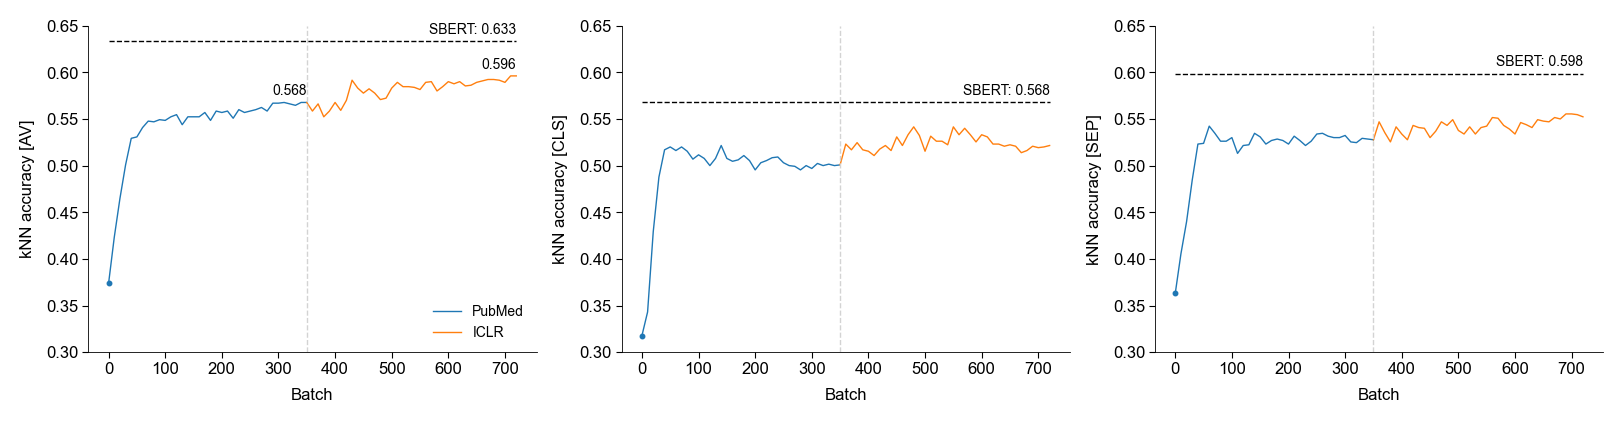

In [20]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(8, 2), dpi=200)

# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

# PubMed
knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_eval_iclr_v1.npy",
)


y_lim_bottom = 0.3
y_lim_top = 0.65
# AV
ax[0].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_pubmed)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].hlines(
    knn_acc_highd_sbert[0],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[0] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].scatter(0, knn_acc_highd[0], c="tab:blue", s=5)
ax[0].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[0].legend(loc="lower right")
ax[0].set_ylim(y_lim_bottom, y_lim_top)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy [AV]")


# CLS
ax[1].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 1],
    label="PubMed",
)
ax[1].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 1],
    label="ICLR",
)
ax[1].hlines(
    knn_acc_highd_sbert[1],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[1].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[1] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[1].scatter(0, knn_acc_highd[1], c="tab:blue", s=5)
ax[1].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[1].set_ylim(y_lim_bottom, y_lim_top)
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("kNN accuracy [CLS]")


# SEP
ax[2].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 2],
    label="PubMed",
)
ax[2].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 2],
    label="ICLR",
)
ax[2].hlines(
    knn_acc_highd_sbert[2],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[2].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[2] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[2]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[2].scatter(0, knn_acc_highd[2], c="tab:blue", s=5)
ax[2].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[2].set_ylim(y_lim_bottom, y_lim_top)
ax[2].set_xlabel("Batch")
ax[2].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / f"knn_accuracies_{model_name}_batches_train_first_pubmed_second_iclr_eval_iclr_v1.png"
)

## Surgery subset

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [ ]:
pubmed_surgery = pubmed[pubmed.Colors == colors_new_legend["surgery"]]
pubmed_surgery

In [ ]:
# select subset for training of the same size as iclr
print(iclr2024.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    pubmed_surgery.shape[0], size=iclr2024.abstract.shape[0], replace=False
)
pubmed_surgery_abstracts_subset = pubmed_surgery.AbstractText.iloc[subset]
print(pubmed_surgery_abstracts_subset.shape)

In [ ]:
%%time
i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# PUBMED TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pubmed_surgery_abstracts_subset, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("PubMed training loader length: ", len(training_loader))

losses, knn_accuracies, model_trained = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_pubmed_surgery_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_surgery_eval_iclr_v1",
    knn_accuracies,
)


# ICLR TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("ICLR training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model_trained,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path
    / saving_path
    / "losses_batches_train_iclr_after_pubmed_surgery_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_surgery_eval_iclr_v1",
    knn_accuracies,
)

### Plot

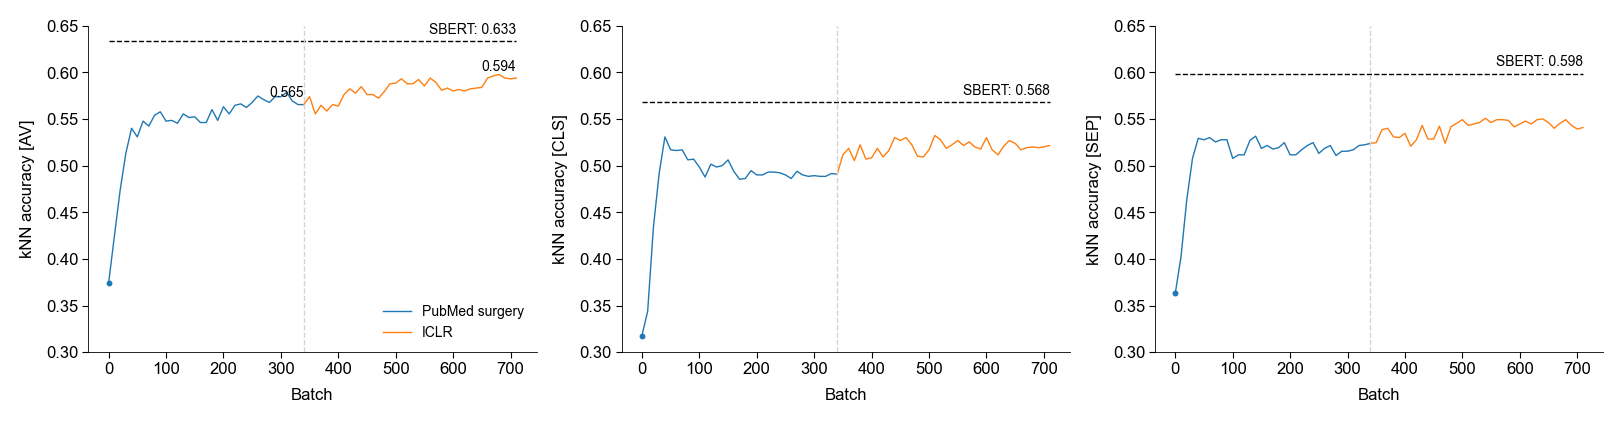

In [46]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(8, 2), dpi=200)

# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

# PubMed
knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_surgery_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_surgery_eval_iclr_v1.npy",
)

y_lim_bottom = 0.3
y_lim_top = 0.65
# AV
ax[0].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed surgery",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_pubmed)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].hlines(
    knn_acc_highd_sbert[0],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[0] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].scatter(0, knn_acc_highd[0], c="tab:blue", s=5)
ax[0].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[0].legend(loc="lower right")
ax[0].set_ylim(y_lim_bottom, y_lim_top)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy [AV]")


# CLS
ax[1].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 1],
    label="PubMed surgery",
)
ax[1].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 1],
    label="ICLR",
)
ax[1].hlines(
    knn_acc_highd_sbert[1],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[1].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[1] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[1].scatter(0, knn_acc_highd[1], c="tab:blue", s=5)
ax[1].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[1].set_ylim(y_lim_bottom, y_lim_top)
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("kNN accuracy [CLS]")


# SEP
ax[2].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 2],
    label="PubMed surgery",
)
ax[2].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 2],
    label="ICLR",
)
ax[2].hlines(
    knn_acc_highd_sbert[2],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[2].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[2] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[2]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[2].scatter(0, knn_acc_highd[2], c="tab:blue", s=5)
ax[2].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[2].set_ylim(y_lim_bottom, y_lim_top)
ax[2].set_xlabel("Batch")
ax[2].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / f"knn_accuracies_{model_name}_batches_train_first_pubmed_surgery_second_iclr_eval_iclr_v1.png"
)

## Cancer subset

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [ ]:
pubmed_cancer = pubmed[pubmed.Colors == colors_new_legend["cancer"]]
pubmed_cancer

In [ ]:
# select subset for training of the same size as iclr
print(iclr2024.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    pubmed_cancer.shape[0], size=iclr2024.abstract.shape[0], replace=False
)
pubmed_cancer_abstracts_subset = pubmed_cancer.AbstractText.iloc[subset]
print(pubmed_cancer_abstracts_subset.shape)

In [ ]:
%%time
i = 1
model_name = model_names[1]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# PUBMED TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pubmed_cancer_abstracts_subset, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("PubMed training loader length: ", len(training_loader))

losses, knn_accuracies, model_trained = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_pubmed_cancer_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_cancer_eval_iclr_v1",
    knn_accuracies,
)


# ICLR TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("ICLR training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model_trained,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path
    / saving_path
    / "losses_batches_train_iclr_after_pubmed_cancer_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_cancer_eval_iclr_v1",
    knn_accuracies,
)

### Plot

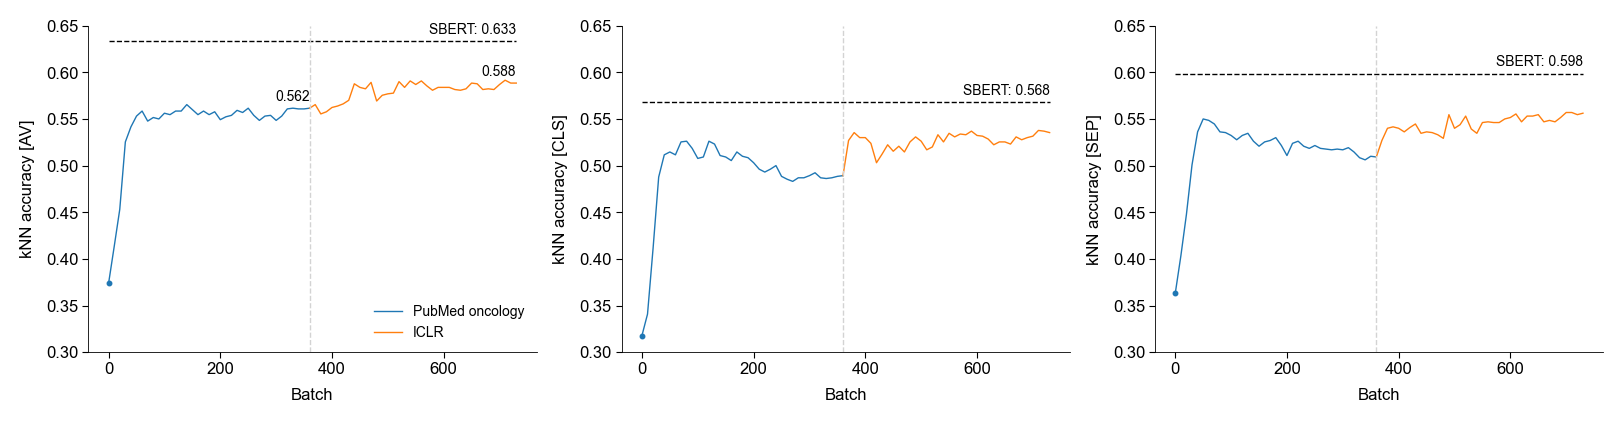

In [47]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(8, 2), dpi=200)

# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

# PubMed
knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_cancer_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_cancer_eval_iclr_v1.npy",
)

y_lim_bottom = 0.3
y_lim_top = 0.65
# AV
ax[0].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed oncology",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_pubmed)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].hlines(
    knn_acc_highd_sbert[0],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[0] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].scatter(0, knn_acc_highd[0], c="tab:blue", s=5)
ax[0].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[0].legend(loc="lower right")
ax[0].set_ylim(y_lim_bottom, y_lim_top)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy [AV]")


# CLS
ax[1].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 1],
    label="PubMed oncology",
)
ax[1].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 1],
    label="ICLR",
)
ax[1].hlines(
    knn_acc_highd_sbert[1],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[1].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[1] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[1].scatter(0, knn_acc_highd[1], c="tab:blue", s=5)
ax[1].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[1].set_ylim(y_lim_bottom, y_lim_top)
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("kNN accuracy [CLS]")


# SEP
ax[2].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 2],
    label="PubMed oncology",
)
ax[2].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 2],
    label="ICLR",
)
ax[2].hlines(
    knn_acc_highd_sbert[2],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[2].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[2] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[2]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[2].scatter(0, knn_acc_highd[2], c="tab:blue", s=5)
ax[2].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[2].set_ylim(y_lim_bottom, y_lim_top)
ax[2].set_xlabel("Batch")
ax[2].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / f"knn_accuracies_{model_name}_batches_train_first_pubmed_cancer_second_iclr_eval_iclr_v1.png"
)

## Immunology subset

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [ ]:
pubmed_immunology = pubmed[pubmed.Colors == colors_new_legend["immunology"]]
pubmed_immunology

In [ ]:
# select subset for training of the same size as iclr
print(iclr2024.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    pubmed_immunology.shape[0], size=iclr2024.abstract.shape[0], replace=False
)
pubmed_immunology_abstracts_subset = pubmed_immunology.AbstractText.iloc[
    subset
]
print(pubmed_immunology_abstracts_subset.shape)

In [ ]:
%%time
i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# PUBMED TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pubmed_immunology_abstracts_subset, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("PubMed training loader length: ", len(training_loader))

losses, knn_accuracies, model_trained = train_loop_batches_eval(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_pubmed_immunology_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_immunology_eval_iclr_v1",
    knn_accuracies,
)


# ICLR TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("ICLR training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model_trained,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path
    / saving_path
    / "losses_batches_train_iclr_after_pubmed_immunology_eval_iclr_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_immunology_eval_iclr_v1",
    knn_accuracies,
)

### Plot

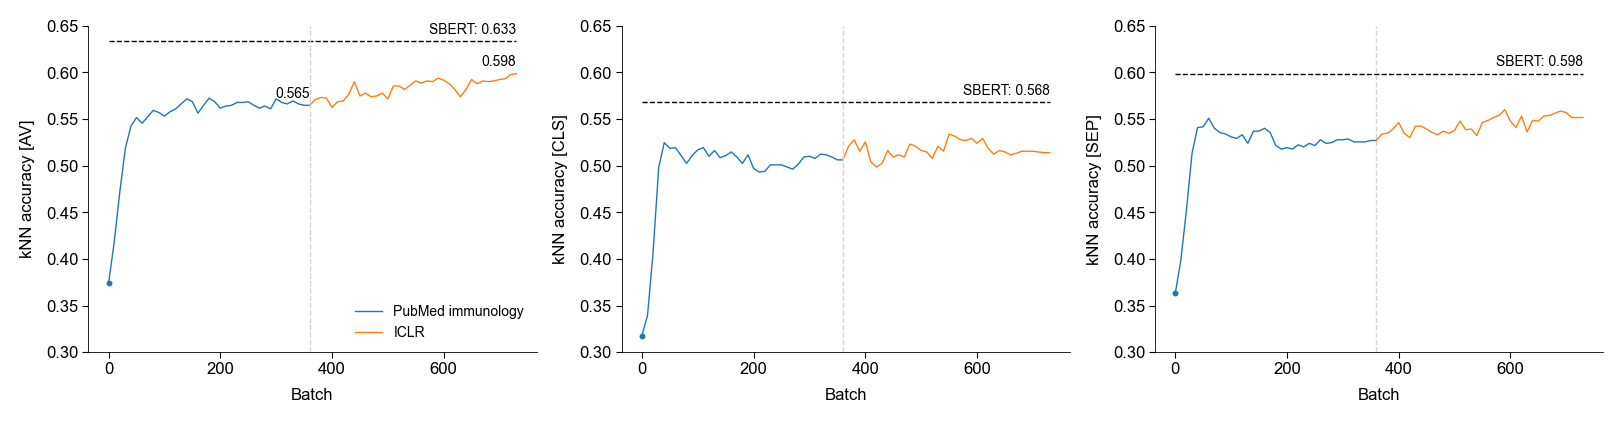

In [61]:
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(8, 2), dpi=200)

# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

# PubMed
knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_immunology_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_immunology_eval_iclr_v1.npy",
)

y_lim_bottom = 0.3
y_lim_top = 0.65
# AV
ax[0].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed immunology",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_pubmed)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    label="ICLR",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0][-1] + 0.005,
    f"{np.vstack(knn_accuracies_iclr)[:, 0][-1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].hlines(
    knn_acc_highd_sbert[0],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[0].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[0] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[0]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[0].scatter(0, knn_acc_highd[0], c="tab:blue", s=5)
ax[0].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[0].legend(loc="lower right")
ax[0].set_ylim(y_lim_bottom, y_lim_top)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy [AV]")


# CLS
ax[1].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 1],
    label="PubMed immunology",
)
ax[1].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 1],
    label="ICLR",
)
ax[1].hlines(
    knn_acc_highd_sbert[1],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[1].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[1] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[1]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[1].scatter(0, knn_acc_highd[1], c="tab:blue", s=5)
ax[1].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[1].set_ylim(y_lim_bottom, y_lim_top)
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("kNN accuracy [CLS]")


# SEP
ax[2].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 2],
    label="PubMed immunology",
)
ax[2].plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 2],
    label="ICLR",
)
ax[2].hlines(
    knn_acc_highd_sbert[2],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="--",
)
ax[2].text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[2] + 0.005,
    f"SBERT: {knn_acc_highd_sbert[2]:.3f}",
    fontsize=5,
    va="bottom",
    ha="right",
)
ax[2].scatter(0, knn_acc_highd[2], c="tab:blue", s=5)
ax[2].vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="lightgrey",
    ls="--",
)
ax[2].set_ylim(y_lim_bottom, y_lim_top)
ax[2].set_xlabel("Batch")
ax[2].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / f"knn_accuracies_{model_name}_batches_train_first_pubmed_immunology_second_iclr_eval_iclr_v1.png"
)

## Combined plot

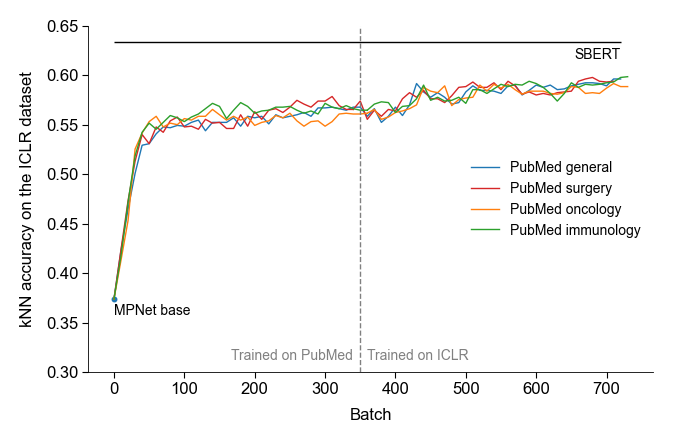

In [74]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3.25, 2.1), dpi=200)
i = 1
model_name = model_names[i]

# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_name_2 = Path("knn_accuracy_" + "sbert" + ".npy")
knn_acc_highd_sbert = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
## random
# PubMed
knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_eval_iclr_v1.npy",
)
## surgery
# PubMed
knn_accuracies_pubmed_surgery = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_surgery_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_surgery = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_surgery_eval_iclr_v1.npy",
)

## cancer
# PubMed
knn_accuracies_pubmed_cancer = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_cancer_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_cancer = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_cancer_eval_iclr_v1.npy",
)

## immunology
# PubMed
knn_accuracies_pubmed_immunology = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_immunology_eval_iclr_v1.npy",
)
# ICLR
knn_accuracies_iclr_immunology = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_after_pubmed_immunology_eval_iclr_v1.npy",
)


y_lim_bottom = 0.3
y_lim_top = 0.65
## AV
# random
ax.plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed general",
    color="tab:blue",
    linestyle="-",
)

ax.plot(
    (len(knn_accuracies_pubmed) - 1) * 10
    + np.arange(len(knn_accuracies_iclr)) * 10,
    np.vstack(knn_accuracies_iclr)[:, 0],
    # label="ICLR",
    color="tab:blue",
    linestyle="-",
)
# surgery
ax.plot(
    np.arange(len(knn_accuracies_pubmed_surgery)) * 10,
    np.vstack(knn_accuracies_pubmed_surgery)[:, 0],
    label="PubMed surgery",
    color="tab:red",
    linestyle="-",
)
ax.plot(
    (len(knn_accuracies_pubmed_surgery) - 1) * 10
    + np.arange(len(knn_accuracies_iclr_surgery)) * 10,
    np.vstack(knn_accuracies_iclr_surgery)[:, 0],
    # label="ICLR",
    color="tab:red",
    linestyle="-",
)
# cancer
ax.plot(
    np.arange(len(knn_accuracies_pubmed_cancer)) * 10,
    np.vstack(knn_accuracies_pubmed_cancer)[:, 0],
    label="PubMed oncology",
    color="tab:orange",
    linestyle="-",
)
ax.plot(
    (len(knn_accuracies_pubmed_cancer) - 1) * 10
    + np.arange(len(knn_accuracies_iclr_cancer)) * 10,
    np.vstack(knn_accuracies_iclr_cancer)[:, 0],
    # label="ICLR",
    color="tab:orange",
    linestyle="-",
)
# immunology
ax.plot(
    np.arange(len(knn_accuracies_pubmed_immunology)) * 10,
    np.vstack(knn_accuracies_pubmed_immunology)[:, 0],
    label="PubMed immunology",
    color="tab:green",
    linestyle="-",
)
ax.plot(
    (len(knn_accuracies_pubmed_immunology) - 1) * 10
    + np.arange(len(knn_accuracies_iclr_immunology)) * 10,
    np.vstack(knn_accuracies_iclr_immunology)[:, 0],
    # label="ICLR",
    color="tab:green",
    linestyle="-",
)
# ax.plot([], [], c="grey", linestyle="-", label="ICLR")
# SBERT
ax.hlines(
    knn_acc_highd_sbert[0],
    0,
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    color="k",
    linestyles="-",
)
ax.text(
    (len(knn_accuracies_pubmed) - 1) * 10
    + (len(knn_accuracies_iclr) - 1) * 10,
    knn_acc_highd_sbert[0] - 0.005,
    f"SBERT",
    fontsize=5,
    va="top",
    ha="right",
)
ax.scatter(0, knn_acc_highd[0], c="tab:blue", s=5)
ax.text(
    0,
    knn_acc_highd[0] - 0.005,
    f"MPNet base",
    fontsize=5,
    va="top",
    ha="left",
)
ax.vlines(
    (len(knn_accuracies_pubmed) - 1) * 10,
    y_lim_bottom,
    y_lim_top,
    color="grey",
    ls="--",
)
ax.text(
    (len(knn_accuracies_pubmed) - 1) * 10 - 10,
    0.31,
    f"Trained on PubMed",
    fontsize=5,
    va="bottom",
    ha="right",
    color="grey",
)
ax.text(
    (len(knn_accuracies_pubmed) - 1) * 10 + 10,
    0.31,
    f"Trained on ICLR",
    fontsize=5,
    va="bottom",
    ha="left",
    color="grey",
)
ax.legend(loc="center right")
ax.set_ylim(y_lim_bottom, y_lim_top)
# ax.set_xlim(left=0)
ax.set_xlabel("Batch")
ax.set_ylabel("kNN accuracy on the ICLR dataset")


fig.savefig(
    figures_path
    / f"knn_accuracies_{model_name}_batches_train_first_pubmed_topic_subset_second_iclr_eval_iclr_combined_v7.png"
)

# Train and evaluate on PubMed

In [8]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [18]:
# select subset for training of the same size as iclr
print(iclr2024.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    pubmed.AbstractText.shape[0],
    size=iclr2024.abstract.shape[0],
    replace=False,
)
pubmed_abstracts_subset = pubmed.AbstractText.iloc[subset]
print(pubmed_abstracts_subset.shape)
print(type(pubmed_abstracts_subset))
print(type(pubmed_abstracts_subset.to_numpy()))
print(type(iclr2024.abstract))

pubmed_colors_subset = pubmed_colors[subset]
print(type(pubmed_colors_subset))

(24347,)
(24347,)
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [19]:
# select subset for eval of the same size as iclr
print(iclr2024.abstract.shape)
np.random.seed(42)
mask_subset_eval = np.random.choice(
    iclr2024.abstract.shape[0],
    size=iclr2024.abstract[labels_iclr != "unlabeled"].shape[0],
    replace=False,
)
print(iclr2024.abstract[labels_iclr != "unlabeled"].shape[0])
print(mask_subset_eval.shape[0])

(24347,)
12997
12997


In [ ]:
%%time
i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# PUBMED TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pubmed_abstracts_subset, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("PubMed training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model,
    training_loader,
    device,
    pubmed_abstracts_subset.to_list(),
    tokenizer,
    mask_subset_eval,
    labels_acc=pubmed_colors_subset[mask_subset_eval],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_pubmed_eval_pubmed_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_eval_pubmed_v1",
    knn_accuracies,
)



## Plot

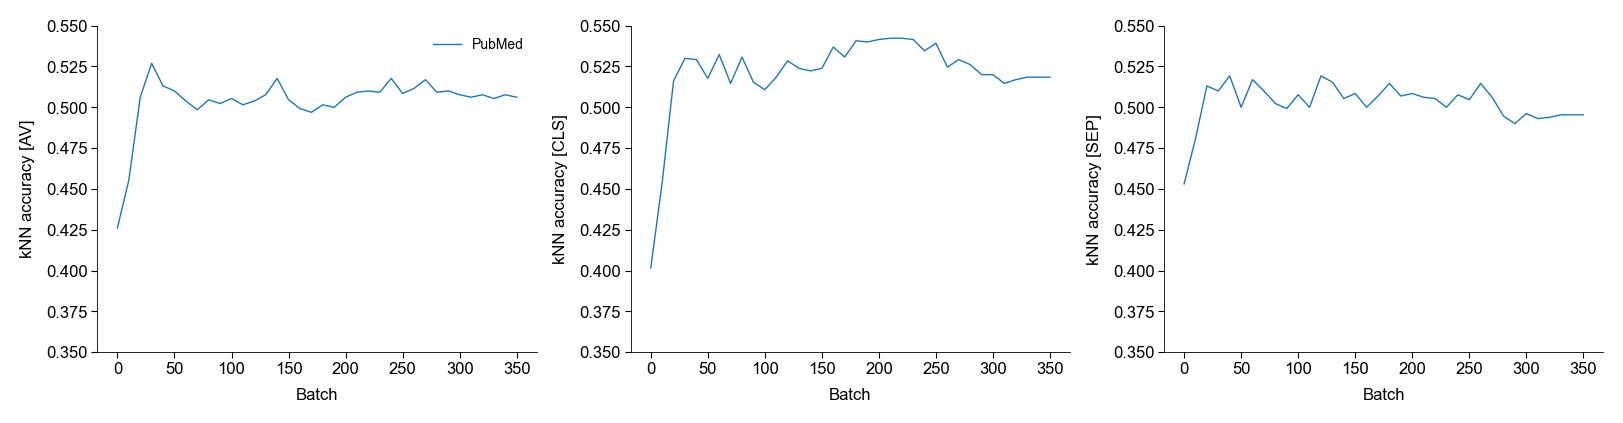

In [69]:
%matplotlib inline

i = 1
model_name = model_names[i]

fig, ax = plt.subplots(1, 3, figsize=(8, 2), dpi=200)
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_eval_pubmed_v1.npy",
)

# ADD SBERT EVENTUALLY

ax[0].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed",
)
# ax[0].scatter(-1, knn_acc_highd[0], c="tab:blue", s=5)
ax[0].set_ylim(0.35, 0.55)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy [AV]")
ax[0].legend()

ax[1].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 1],
    label="PubMed",
)
# ax[1].scatter(-1, knn_acc_highd[1], c="tab:blue", s=5)
ax[1].set_ylim(0.35, 0.55)
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("kNN accuracy [CLS]")

ax[2].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 2],
    label="PubMed",
)
# ax[2].scatter(-1, knn_acc_highd[2], c="tab:blue", s=5)
ax[2].set_ylim(0.35, 0.55)
ax[2].set_xlabel("Batch")
ax[2].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / f"knn_accuracies_{model_name}_batches_train_pubmed_eval_pubmed_v1.png"
)

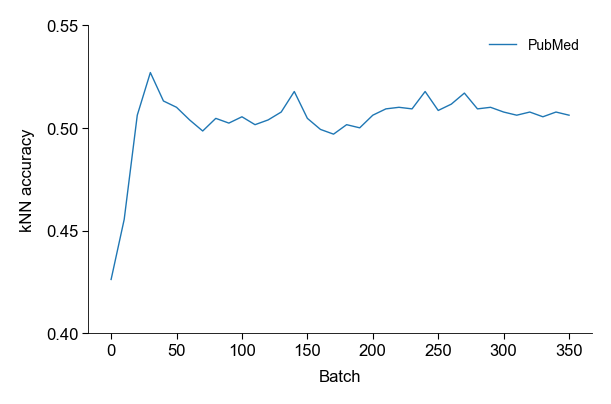

In [9]:
%matplotlib inline

i = 1
model_name = model_names[i]

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200)
# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_eval_pubmed_v1.npy",
)

# ADD SBERT EVENTUALLY

ax.plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed",
)
# ax.scatter(-1, knn_acc_highd[0], c="tab:blue", s=5)
ax.set_ylim(0.4, 0.55)
ax.set_xlabel("Batch")
ax.set_ylabel("kNN accuracy")
ax.set_yticks(np.arange(0.4, 0.6, 0.05))
ax.legend()


fig.savefig(
    figures_path
    / f"knn_accuracies_{model_name}_batches_train_pubmed_eval_pubmed_v2.png"
)

In [10]:
%matplotlib inline

i = 1
model_name = model_names[i]

# load
saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_eval_pubmed_v1.npy",
)

print(
    np.vstack(knn_accuracies_pubmed)[0, 0],
    np.vstack(knn_accuracies_pubmed)[-1, 0],
)

0.42615384615384616 0.5061538461538462


In [ ]:
# SBERT
[0.55307692 0.53461538 0.53461538]

## Sanity check

#### MPNet

In [46]:
i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])
model.to(device)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [47]:
label_mask = mask_subset_eval
labels_acc = pubmed_colors_subset[mask_subset_eval]

In [48]:
%%time
(
    embedding_cls,
    embedding_sep,
    embedding_av,
) = generate_embeddings(
    pubmed_abstracts_subset.to_list(),
    tokenizer,
    model,
    device,
    batch_size=256,
)

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 2min 35s, sys: 3min 11s, total: 5min 47s
Wall time: 3min 28s


In [49]:
%%time
knn_acc_mpnet = knn_accuracy(
    [
        embedding_av[label_mask],
        embedding_cls[label_mask],
        embedding_sep[label_mask],
    ],
    labels_acc,
)
print(knn_acc_mpnet)

[0.42615385 0.40153846 0.45307692]
CPU times: user 9.52 s, sys: 2.54 s, total: 12.1 s
Wall time: 628 ms


In [50]:
%%time
knn_acc = knn_accuracy(
    [
        embedding_av,
        embedding_cls,
        embedding_sep,
    ],
    pubmed_colors_subset,
)
print(knn_acc)

[0.46817248 0.40698152 0.47679671]
CPU times: user 17.2 s, sys: 136 ms, total: 17.3 s
Wall time: 808 ms


#### SBERT

In [51]:
i = 2
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])
model.to(device)

Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [52]:
label_mask = mask_subset_eval
labels_acc = pubmed_colors_subset[mask_subset_eval]

In [53]:
%%time
(
    embedding_cls,
    embedding_sep,
    embedding_av,
) = generate_embeddings(
    pubmed_abstracts_subset.to_list(),
    tokenizer,
    model,
    device,
    batch_size=256,
)

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CPU times: user 2min 15s, sys: 3min 16s, total: 5min 32s
Wall time: 3min 29s


In [54]:
%%time
knn_acc_sbert = knn_accuracy(
    [
        embedding_av[label_mask],
        embedding_cls[label_mask],
        embedding_sep[label_mask],
    ],
    labels_acc,
)
print(knn_acc_sbert)

[0.55307692 0.53461538 0.53461538]
CPU times: user 8.43 s, sys: 3.7 s, total: 12.1 s
Wall time: 478 ms


In [55]:
%%time
knn_acc = knn_accuracy(
    [
        embedding_av,
        embedding_cls,
        embedding_sep,
    ],
    pubmed_colors_subset,
)
print(knn_acc)

[0.59219713 0.54620123 0.54702259]
CPU times: user 16.2 s, sys: 32.9 ms, total: 16.2 s
Wall time: 743 ms


#### TF-IDF

In [56]:
%%time
%%memit

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features_pubmed_subset = vectorizer.fit_transform(
    pubmed_abstracts_subset.to_list()
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 6969.27 MiB, increment: 0.00 MiB
CPU times: user 2.94 s, sys: 504 ms, total: 3.44 s
Wall time: 3.69 s


In [57]:
label_mask = mask_subset_eval
labels_acc = pubmed_colors_subset[mask_subset_eval]

In [58]:
%%time
knn_acc = knn_accuracy(
    tfidf_features_pubmed_subset[label_mask],
    labels_acc,
)
print(knn_acc)

0.48384615384615387
CPU times: user 2min 32s, sys: 3.85 s, total: 2min 36s
Wall time: 7.05 s


## Neuroscience subset

##### Wrong dataframe

In [187]:
# THIS SUBSET DOES NOT FIT THE NSC COLORS VARIABLE FROM PUBMED PAPAER FIG 3
# pubmed_neuroscience = pubmed[
#     pubmed.Colors == colors_new_legend["neuroscience"]
# ]
# pubmed_neuroscience

In [ ]:
# define vocabulary swap
new_colors_legend_swap = {
    value: key for key, value in nsc_colors_reparsed_legend.items()
}

In [ ]:
i = 3
print(new_colors_legend_swap[nsc_colors_reparsed[i]])
print(pubmed_neuroscience.Title.iloc[i])

Cognitive
Tetracyclic Truncated Analogue of the Marine Toxin Gambierol Modifies NMDA, Tau, and Amyloid β Expression in Mice Brains: Implications in AD Pathology.


##### With other dataframe

In [59]:
# import clean_df_updated
clean_df_updated_reparsed_filtered_with_authors_ISSN = pd.read_pickle(
    berenslab_data_path
    / "clean_df_updated_reparsed_filtered_with_authors_ISSN"
)

In [60]:
clean_df_updated_reparsed_filtered_with_authors_ISSN.head()

,PMID,Title,AbstractText,Language,Journal,Date,NameFirstAuthor,NameLastAuthor,ISSN,filename
0,1133452,Reflections on the special senses in relation ...,"In congenital blindness, the absence of vision...",eng,Journal of the American Psychoanalytic Associa...,1975,H R,H R,0003-0651,pubmed21n0038.xml
1,1133453,Tracing a memory.,Comparisons of the nests of associations withi...,eng,Journal of the American Psychoanalytic Associa...,1975,K H,K H,0003-0651,pubmed21n0038.xml
2,1133454,Some pitfalls in the assessment of analyzabili...,We have described some of the problems encount...,eng,Journal of the American Psychoanalytic Associa...,1975,H,P,0003-0651,pubmed21n0038.xml
3,1133455,"Variability of the iron, copper and mercury co...","The relative iron, copper and mercury contents...",eng,The journal of histochemistry and cytochemistr...,1975 May,J R,R S,0022-1554,pubmed21n0038.xml
4,1133526,"Hypophysectomy of the tammar wallaby, Macropus...",A technique of hypophysectomy and regimes of p...,eng,The Journal of endocrinology,1975 Mar,J P,J P,0022-0795,pubmed21n0038.xml


In [61]:
# load
# legend colors
pickle_in = open(
    "../../../pubmed-landscape/results/variables/colors_new_legend.pkl", "rb"
)
colors_new_legend = pickle.load(pickle_in)

colors_new = np.load(
    "../../../pubmed-landscape/results/variables/colors_new.npy",
    allow_pickle=True,
)

In [62]:
neuroscience_subset_from_original = (
    clean_df_updated_reparsed_filtered_with_authors_ISSN[
        colors_new == colors_new_legend["neuroscience"]
    ]
)
print(neuroscience_subset_from_original.shape)
neuroscience_subset_from_original.head()

(240135, 10)


,PMID,Title,AbstractText,Language,Journal,Date,NameFirstAuthor,NameLastAuthor,ISSN,filename
10768,22454142,Involvement of PACAP/ADNP signaling in the res...,Malignant peripheral nerve sheath tumors (MPNS...,eng,Journal of molecular neuroscience : MN,2012 Nov,Alessandro,Velia,1559-1166,pubmed21n0722.xml
10769,22454143,Neurotrophin expression is not affected in ute...,To investigate the involvement of neurotrophin...,eng,Journal of molecular neuroscience : MN,2012 Jul,Maria Luisa,Sylvia,1559-1166,pubmed21n0722.xml
11099,22454616,The role of reward in dynamic decision making.,The present study investigates two aspects of ...,eng,Frontiers in neuroscience,2012,Magda,Magda,1662-453X,pubmed21n0722.xml
11100,22454617,Steroid modulation of hippocampal plasticity: ...,Several new observations have shifted the view...,eng,Frontiers in cellular neuroscience,2012,Nicola,Menahem,1662-5102,pubmed21n0722.xml
11103,22454620,The endocannabinoid transport inhibitor AM404 ...,Cannabinoid compounds may influence both emoti...,eng,Frontiers in behavioral neuroscience,2012,Patrizia,Vincenzo,1662-5153,pubmed21n0722.xml


In [63]:
# load results
nsc_colors_reparsed = np.load(
    variables_pubmed_path / "nsc_colors_reparsed.npy", allow_pickle=True
)
# legend colors
pickle_in = open(
    variables_pubmed_path / "nsc_colors_reparsed_legend.pkl", "rb"
)
nsc_colors_reparsed_legend = pickle.load(pickle_in)

In [64]:
print(len(np.unique(nsc_colors_reparsed)))

34


In [65]:
# select subset for training of the same size as iclr
print(iclr2024.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    neuroscience_subset_from_original.shape[0],
    size=iclr2024.abstract.shape[0],
    replace=False,
)
pubmed_neuroscience_abstracts_subset = (
    neuroscience_subset_from_original.AbstractText.iloc[subset]
)
print(pubmed_neuroscience_abstracts_subset.shape)
print(type(pubmed_neuroscience_abstracts_subset))

pubmed_neuroscience_labels_subset = nsc_colors_reparsed[subset]
print(pubmed_neuroscience_labels_subset.shape)
print(type(pubmed_neuroscience_labels_subset))

(24347,)
(24347,)
<class 'pandas.core.series.Series'>
(24347,)
<class 'numpy.ndarray'>


In [66]:
print(len(np.unique(pubmed_neuroscience_labels_subset)))

34


In [67]:
# select subset for eval of the same size as iclr
print(iclr2024.abstract.shape)
np.random.seed(42)
mask_subset_eval = np.random.choice(
    iclr2024.abstract.shape[0],
    size=iclr2024.abstract[labels_iclr != "unlabeled"].shape[0],
    replace=False,
)
print(iclr2024.abstract[labels_iclr != "unlabeled"].shape[0])
print(mask_subset_eval.shape[0])

(24347,)
12997
12997


In [ ]:
%%time
i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# PUBMED TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pubmed_neuroscience_abstracts_subset, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("PubMed training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model,
    training_loader,
    device,
    pubmed_neuroscience_abstracts_subset.to_list(),
    tokenizer,
    mask_subset_eval,
    labels_acc=pubmed_neuroscience_labels_subset[mask_subset_eval],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())/ Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_pubmed_nsc_eval_pubmed_nsc_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_nsc_eval_pubmed_nsc_v1",
    knn_accuracies,
)



### Plot

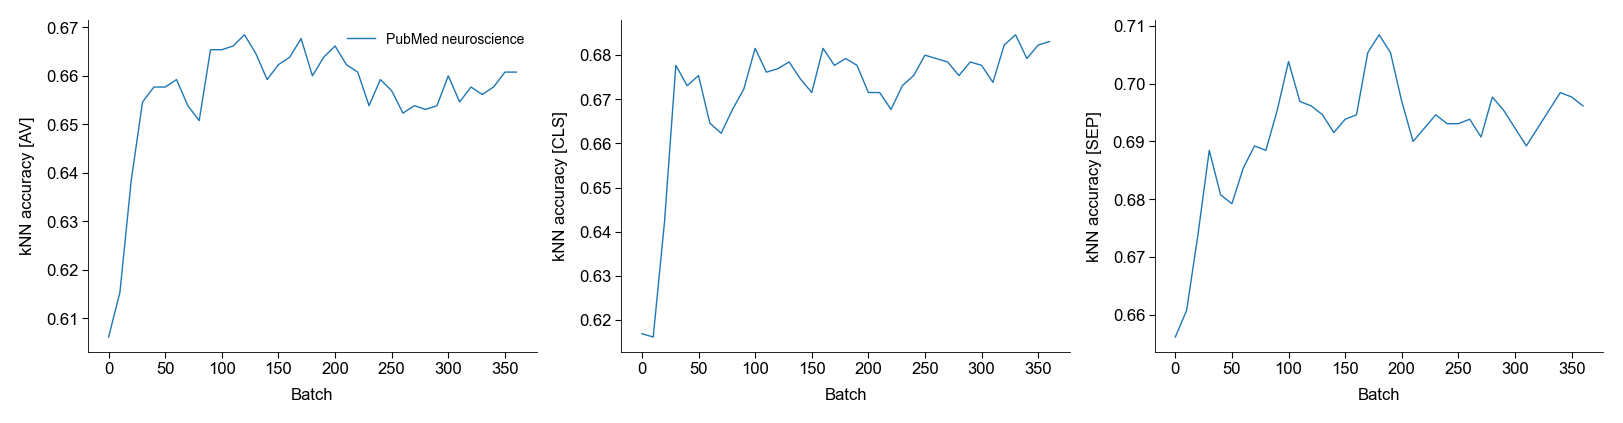

In [45]:
%matplotlib inline

i = 1
model_name = model_names[i]

fig, ax = plt.subplots(1, 3, figsize=(8, 2), dpi=200)

# load
# saving_name_2 = Path("knn_accuracy_" + "bert" + ".npy")  -- THEY ARE NOT COMPUTED FOR PUBMED
# knn_acc_highd = np.load(variables_path / saving_name_2)

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_nsc_eval_pubmed_nsc_v1.npy",
)


ax[0].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed neuroscience",
)
# ax[0].scatter(-1, knn_acc_highd[0], c="tab:blue", s=5)
# ax[0].set_ylim(0.35, 0.55)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy [AV]")
ax[0].legend()

ax[1].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 1],
    label="PubMed",
)
# ax[1].scatter(-1, knn_acc_highd[1], c="tab:blue", s=5)
# ax[1].set_ylim(0.35, 0.55)
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("kNN accuracy [CLS]")

ax[2].plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 2],
    label="PubMed",
)
# ax[2].scatter(-1, knn_acc_highd[2], c="tab:blue", s=5)
# ax[2].set_ylim(0.35, 0.55)
ax[2].set_xlabel("Batch")
ax[2].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / f"knn_accuracies_{model_name}_batches_train_pubmed_nsc_eval_pubmed_nsc_v1.png"
)

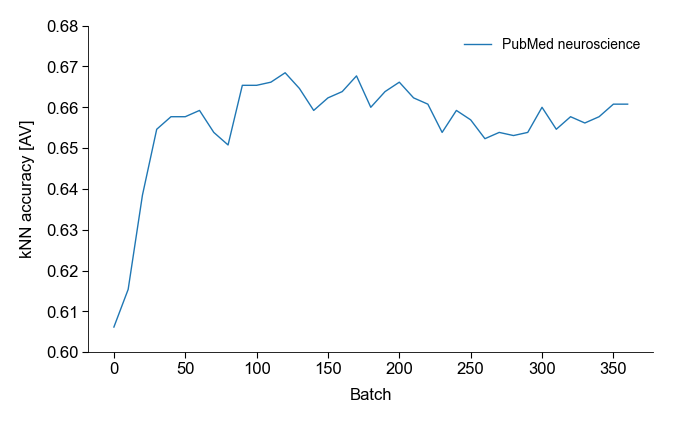

In [19]:
%matplotlib inline

i = 1
model_name = model_names[i]

fig, ax = plt.subplots(figsize=(3.25, 2), dpi=200)

# load
# saving_name_2 = Path("knn_accuracy_" + "bert" + ".npy")  -- THEY ARE NOT COMPUTED FOR PUBMED
# knn_acc_highd = np.load(variables_path / saving_name_2)

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
(variables_path / saving_path).mkdir(exist_ok=True)

knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_nsc_eval_pubmed_nsc_v1.npy",
)


ax.plot(
    np.arange(len(knn_accuracies_pubmed)) * 10,
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed neuroscience",
)
# ax.scatter(-1, knn_acc_highd[0], c="tab:blue", s=5)
ax.set_ylim(0.6, 0.68)
ax.set_xlabel("Batch")
ax.set_ylabel("kNN accuracy [AV]")
ax.legend()


fig.savefig(
    figures_path
    / f"knn_accuracies_{model_name}_batches_train_pubmed_nsc_eval_pubmed_nsc_v2.png"
)

## Covid subset -- FROM HERE ON NOT RUN

In [ ]:
# import clean_df_updated
clean_df_updated_reparsed_filtered_with_authors_ISSN = pd.read_pickle(
    berenslab_data_path
    / "clean_df_updated_reparsed_filtered_with_authors_ISSN"
)

tcmalloc: large alloc 1073741824 bytes == 0x7f844c5c0000 @ 
tcmalloc: large alloc 1233903616 bytes == 0x7f82b7bc2000 @ 
tcmalloc: large alloc 2147483648 bytes == 0x7f81efc82000 @ 
tcmalloc: large alloc 1542381568 bytes == 0x7f8173354000 @ 
tcmalloc: large alloc 1927979008 bytes == 0x7f8077f2a000 @ 


In [226]:
clean_df_updated_reparsed_filtered_with_authors_ISSN.head()

,PMID,Title,AbstractText,Language,Journal,Date,NameFirstAuthor,NameLastAuthor,ISSN,filename
0,1133452,Reflections on the special senses in relation ...,"In congenital blindness, the absence of vision...",eng,Journal of the American Psychoanalytic Associa...,1975,H R,H R,0003-0651,pubmed21n0038.xml
1,1133453,Tracing a memory.,Comparisons of the nests of associations withi...,eng,Journal of the American Psychoanalytic Associa...,1975,K H,K H,0003-0651,pubmed21n0038.xml
2,1133454,Some pitfalls in the assessment of analyzabili...,We have described some of the problems encount...,eng,Journal of the American Psychoanalytic Associa...,1975,H,P,0003-0651,pubmed21n0038.xml
3,1133455,"Variability of the iron, copper and mercury co...","The relative iron, copper and mercury contents...",eng,The journal of histochemistry and cytochemistr...,1975 May,J R,R S,0022-1554,pubmed21n0038.xml
4,1133526,"Hypophysectomy of the tammar wallaby, Macropus...",A technique of hypophysectomy and regimes of p...,eng,The Journal of endocrinology,1975 Mar,J P,J P,0022-0795,pubmed21n0038.xml


In [227]:
mask_covid_2 = np.load(variables_pubmed_path / "mask_covid_2.npy")

tsne_reparsed = np.load(variables_pubmed_path / "tsne_reparsed.npy")

# mask island 1
tsne = np.vstack((-tsne_reparsed[:, 0], tsne_reparsed[:, 1])).T

right = 15
left = -15
top = -40
bottom = -85

mask_covid_island = (
    mask_covid_2
    & (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

In [228]:
# load
pickle_in = open(variables_pubmed_path / "covid_legend.pkl", "rb")
covid_legend = pickle.load(pickle_in)

covid_colors = np.load(
    variables_pubmed_path / "covid_colors.npy", allow_pickle=True
)

In [229]:
covid_colors.shape

(78732,)

In [230]:
covid_subset_from_original = (
    clean_df_updated_reparsed_filtered_with_authors_ISSN[mask_covid_island]
)
print(covid_subset_from_original.shape)
covid_subset_from_original.head()

(78732, 10)


,PMID,Title,AbstractText,Language,Journal,Date,NameFirstAuthor,NameLastAuthor,ISSN,filename
609928,32954048,Clinical laboratory characteristics of severe ...,To identify clinical characteristics of severe...,eng,Clinical epidemiology and global health,2020 Sep 15,Xiang,Gang,2452-0918,pubmed21n1051.xml
609960,32954094,Piecewise quadratic growth during the 2019 nov...,The temporal growth in the number of deaths in...,eng,Infectious Disease Modelling,2020,Axel,Axel,2468-0427,pubmed21n1051.xml
610076,32954232,Tracing asymptomatic SARS-CoV-2 carriers among...,Asymptomatic carriers were positive for severe...,eng,EClinicalMedicine,2020 Sep,Fuling,Lin,2589-5370,pubmed21n1051.xml
610090,32954248,Universal testing for severe acute respiratory...,The coronavirus disease 2019 pandemic caused b...,eng,American journal of obstetrics & gynecology MFM,2020 Nov,Whitney R,Sindhu K,2589-9333,pubmed21n1051.xml
610199,32954371,COVID-19 and mental health: How one pandemic c...,The COVID-19 pandemic disproportionately affec...,eng,Journal of behavioral and cognitive therapy,2020 Sep,Joel,Joel,2589-9791,pubmed21n1051.xml


In [231]:
for i in range(5):
    print(covid_subset_from_original.AbstractText.iloc[i])

To identify clinical characteristics of severe patients with COVID-19. The WHO database of publications on COVID-19 and PubMed were searched from inception to March 20, 2020 and all valuable studies were analyzed using Stata 15.0. We selected forty-four studies with 13,497 patients. In the comparison of severe and non-severe groups, age over 50 (OR = 4.090; 95% CI = 2.422-6.907, P = 0.000) and underlying disease (OR = 3.992; 95% CI = 2.631-6.507, P = 0.000) are risk factors. Female gender (OR = 0.740; 95% CI = 0.622-0.881, P = 0.001) is a protective factor. Characteristics like dyspnea (OR = 4.914; 95% CI = 3.069-7.867, P = 0.000), lymphopenia (OR = 5.528; 95% CI = 3.484-8.772, P = 0.000), thrombocytopenia (OR = 3.623; 95% CI = 1.034-12.691, P = 0.044), elevated C-reactive protein (OR = 5.217; 95% CI = 2.459-11.070, P = 0.000) and D-dimer (OR = 3.780; 95% CI = 1.481-9.648, P = 0.005) were more frequently in severe cases. Diffuse lesions and consolidation (OR = 4.680; 95% CI = 3.183-6.8

In [232]:
# select subset for training of the same size as iclr
print(iclr.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    covid_subset_from_original.shape[0],
    size=iclr.abstract.shape[0],
    replace=False,
)
pubmed_covid_abstracts_subset = covid_subset_from_original.AbstractText.iloc[
    subset
]
print(pubmed_covid_abstracts_subset.shape)
print(type(pubmed_covid_abstracts_subset))

pubmed_covid_labels_subset = covid_colors[subset]
print(pubmed_covid_labels_subset.shape)
print(type(pubmed_covid_labels_subset))

(16536,)
(16536,)
<class 'pandas.core.series.Series'>
(16536,)
<class 'numpy.ndarray'>


In [233]:
print(len(np.unique(pubmed_covid_labels_subset)))

28


In [234]:
# select subset for training of the same size as iclr
print(iclr.abstract.shape)
np.random.seed(42)
mask_subset_eval = np.random.choice(
    iclr.abstract.shape[0], size=iclr.abstract[labeled].shape[0], replace=False
)
print(iclr.abstract[labeled].shape[0])
print(mask_subset_eval.shape[0])

(16536,)
6849
6849


In [235]:
%%time
i = 0
model_name = model_names[0]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# PUBMED TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pubmed_covid_abstracts_subset, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("PubMed training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model,
    training_loader,
    device,
    pubmed_covid_abstracts_subset.to_list(),
    tokenizer,
    mask_subset_eval,
    labels_acc=pubmed_covid_labels_subset[mask_subset_eval],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_pubmed_covid_eval_pubmed_covid_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_covid_eval_pubmed_covid_v1",
    knn_accuracies,
)



Model:  BERT
Running on device: cuda
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
PubMed training loader length:  241


  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Plot

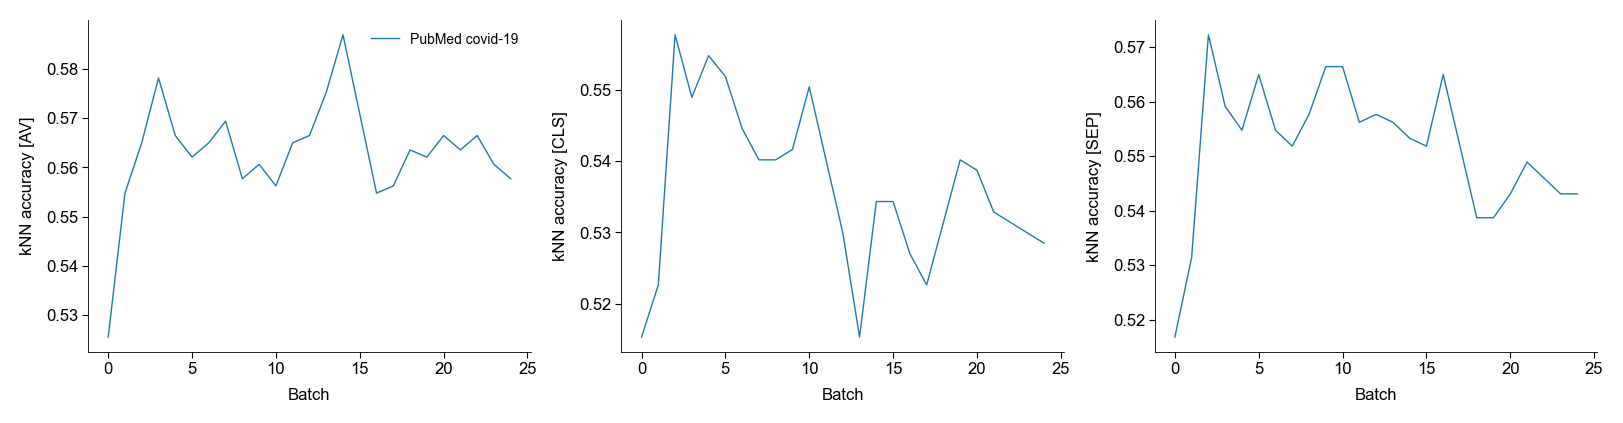

In [20]:
%matplotlib inline
n_epochs = 2
i = 0
model_name = model_names[0]

fig, ax = plt.subplots(1, 3, figsize=(8, 2), dpi=200)

# load
# saving_name_2 = Path("knn_accuracy_" + "bert" + ".npy")  -- THEY ARE NOT COMPUTED FOR PUBMED
# knn_acc_highd = np.load(variables_path / saving_name_2)

saving_path = Path("embeddings_" + model_name.lower())
(variables_path / saving_path).mkdir(exist_ok=True)

# losses_pubmed = np.load(
#     variables_path / saving_path / "losses_batches_train_pubmed_eval_pubmed_v1.npy",
# )
knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_pubmed_covid_eval_pubmed_covid_v1.npy",
)


ax[0].plot(
    np.arange(25),
    np.vstack(knn_accuracies_pubmed)[:, 0],
    label="PubMed covid-19",
)
# ax[0].scatter(-1, knn_acc_highd[0], c="tab:blue", s=5)
# ax[0].set_ylim(0.35, 0.55)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy [AV]")
ax[0].legend()

ax[1].plot(
    np.arange(25), np.vstack(knn_accuracies_pubmed)[:, 1], label="PubMed"
)
# ax[1].scatter(-1, knn_acc_highd[1], c="tab:blue", s=5)
# ax[1].set_ylim(0.35, 0.55)
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("kNN accuracy [CLS]")

ax[2].plot(
    np.arange(25), np.vstack(knn_accuracies_pubmed)[:, 2], label="PubMed"
)
# ax[2].scatter(-1, knn_acc_highd[2], c="tab:blue", s=5)
# ax[2].set_ylim(0.35, 0.55)
ax[2].set_xlabel("Batch")
ax[2].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "knn_accuracies_bert_batches_train_pubmed_covid_eval_pubmed_covid_v1.png"
)

## Two-class setting

### psychology - psychiatry

In [ ]:
pubmed_psy = pubmed[(pubmed.Colors == colors_new_legend["psychology"]) | (pubmed.Colors == colors_new_legend["psychiatry"])]
pubmed_psy

,PMID,Title,AbstractText,Language,Journal,Date,filename,Colors
2,24705805,Incisional hernia in recipients of adult to ad...,After receiving a living donor liver transplan...,eng,World journal of surgery,2014 Aug,pubmed21n0790.xml,#006FA6
9,31626936,Prevalence and Risk Factors of Preoperative De...,The purpose of this study is to determine the ...,eng,Annals of vascular surgery,2020 Apr,pubmed21n1007.xml,#006FA6
22,28396234,Intraoral Vacuum-Assisted Closure Therapy-A Pi...,"For approximately 2 decades, vacuum-assisted c...",eng,Journal of oral and maxillofacial surgery : of...,2017 Oct,pubmed21n0902.xml,#006FA6
27,24635156,Meta-analysis of infectious endophthalmitis af...,To investigate the rate of endophthalmitis aft...,eng,"Ophthalmic surgery, lasers & imaging retina",2014 Mar-Apr,pubmed21n0788.xml,#006FA6
40,28004037,Differential compensation mechanisms define re...,Recent sequencing studies of head and neck squ...,eng,Otorhinolaryngology-head and neck surgery,2016,pubmed21n0891.xml,#006FA6
...,...,...,...,...,...,...,...,...
999923,19628359,Isolated femoral endarterectomy: impact of SFA...,Atherosclerotic occlusive disease of the femor...,eng,Journal of vascular surgery,2009 Oct,pubmed21n0634.xml,#006FA6
999934,7732112,Tissue humoral response to intact and ruptured...,Biopsies of the fibrous capsule in 31 women un...,eng,Plastic and reconstructive surgery,1995 May,pubmed21n0257.xml,#006FA6
999942,30642221,Occupational Burnout among Otolaryngology-Head...,Surgical trainee burnout has gained attention ...,eng,Otolaryngology--head and neck surgery : offici...,2019 03,pubmed21n0975.xml,#006FA6
999954,30277944,A New Technique for Sagittal Synostosis: A Plu...,The authors devised a multiple small incisions...,eng,The Journal of craniofacial surgery,2018 Nov,pubmed21n0963.xml,#006FA6


# MTEB datasets

In [12]:
from datasets import load_dataset

ds_biorxiv = load_dataset("mteb/biorxiv-clustering-p2p")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /gpfs01/berens/user/rgonzalesmarquez/.cache/huggingface/datasets/mteb___json/mteb--biorxiv-clustering-p2p-a360dc94b4066ca8/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
ds_biorxiv  # ["test"]

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 10
    })
})

In [26]:
type(ds_biorxiv.data["test"])

datasets.table.MemoryMappedTable

In [43]:
print(type(ds_biorxiv.data["test"].to_pandas().sentences.iloc[0]))
print(type(ds_biorxiv.data["test"].to_pandas().labels.iloc[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [48]:
ds_biorxiv.data["test"].to_pandas().labels.iloc[0]

array(['neuroscience', 'neuroscience', 'genetics', ..., 'ecology',
       'evolutionary biology', 'neuroscience'], dtype=object)

In [53]:
np.hstack(ds_biorxiv.data["test"].to_pandas().labels.to_numpy()).shape

(75000,)

In [54]:
biorxiv_abstracts = np.hstack(
    ds_biorxiv.data["test"].to_pandas().sentences.to_numpy()
)
biorxiv_labels = np.hstack(
    ds_biorxiv.data["test"].to_pandas().labels.to_numpy()
)

print(biorxiv_abstracts.shape)
print(biorxiv_labels.shape)

(75000,)
(75000,)


In [98]:
biorxiv_abstracts[0]
biorxiv_labels[0]

'neuroscience'

## Data distribution

In [59]:
unique_labels, counts = np.unique(biorxiv_labels, return_counts=True)
print(len(unique_labels))
print(unique_labels)

26
['animal behavior and cognition' 'biochemistry' 'bioengineering'
 'bioinformatics' 'biophysics' 'cancer biology' 'cell biology'
 'developmental biology' 'ecology' 'epidemiology' 'evolutionary biology'
 'genetics' 'genomics' 'immunology' 'microbiology' 'molecular biology'
 'neuroscience' 'paleontology' 'pathology' 'pharmacology and toxicology'
 'physiology' 'plant biology' 'scientific communication and education'
 'synthetic biology' 'systems biology' 'zoology']


In [57]:
labelColors = [
    "#d21820",
    "#1869ff",
    "#008a00",
    "#f36dff",
    "#710079",
    "#aafb00",
    "#00bec2",
    "#ffa235",
    "#5d3d04",
    "#08008a",
    "#005d5d",
    "#9a7d82",
    "#a2aeff",
    "#96b675",
    "#9e28ff",
    "#4d0014",
    "#ffaebe",
    "#ce0092",
    "#00ffb6",
    "#002d00",
    "#9e7500",
    "#3d3541",
    "#f3eb92",
    "#65618a",
    "#8a3d4d",
    "#5904ba",
    "#558a71",
    "#b2bec2",
    "#ff5d82",
    "#1cc600",
    "#92f7ff",
    "#2d86a6",
    "#395d28",
    "#ebceff",
    "#ff5d00",
    "#a661aa",
    "#860000",
    "#350059",
    "#00518e",
    "#9e4910",
    "#cebe00",
    "#002828",
    "#00b2ff",
    "#caa686",
    "#be9ac2",
    "#2d200c",
    "#756545",
    "#8279df",
    "#00c28a",
    "#bae7c2",
]

labelColors = np.array(labelColors)

dict_colors = dict(zip(unique_labels, labelColors[: len(unique_labels)]))

In [66]:
dict_colors.values

<function dict.values>

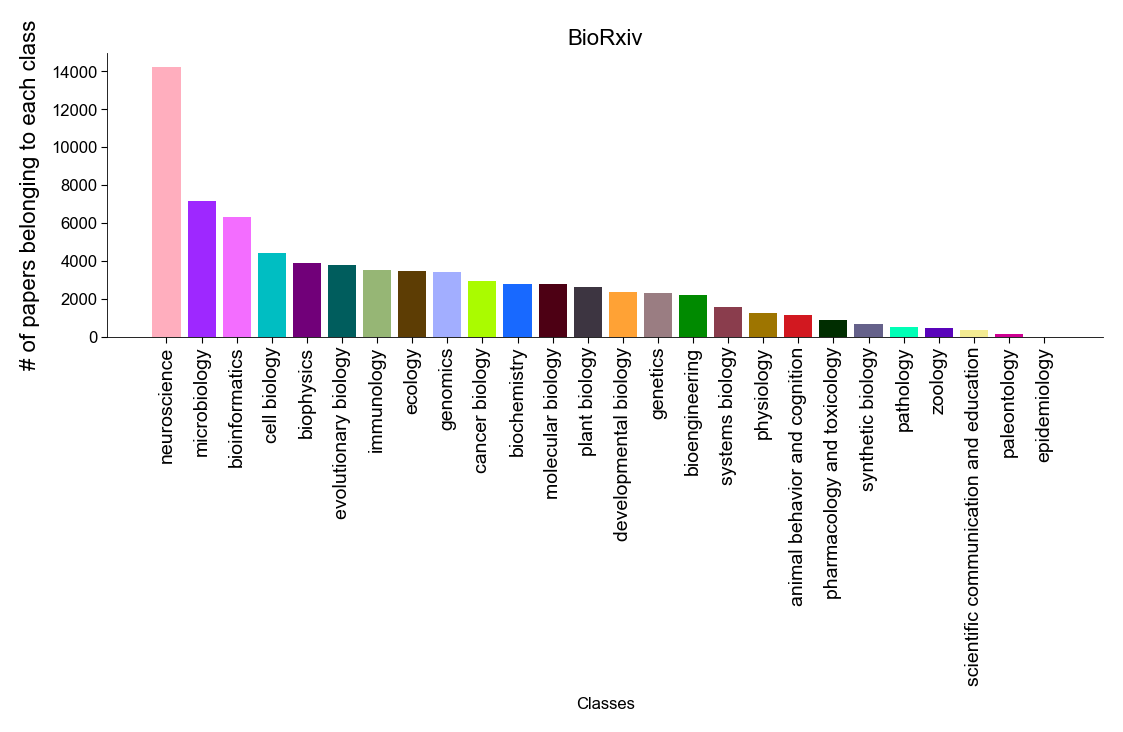

In [65]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 3.5), dpi=200)
ax.bar(
    np.arange(len(counts)),
    np.flip(np.sort(counts)),
    color=np.array(list(dict_colors.values()))[np.flip(np.argsort(counts))],
)

ax.set_xticks(
    np.arange(len(counts)),
    labels=unique_labels[np.flip(np.argsort(counts))],
    rotation="vertical",
    fontsize=7,
)
ax.set_ylabel("# of papers belonging to each class", fontsize=8)
ax.set_xlabel("Classes")
ax.set_title("BioRxiv")


fig.savefig(figures_path / "barplot_class_distribution_biorxiv.png")

## Construct my subset

In [76]:
# select subset for training of the same size as iclr
print(iclr.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    biorxiv_abstracts.shape[0], size=iclr.abstract.shape[0], replace=False
)
biorxiv_abstracts_subset = biorxiv_abstracts[subset]
print(biorxiv_abstracts_subset.shape)
print(type(biorxiv_abstracts_subset))

print(type(iclr.abstract))

biorxiv_labels_subset = biorxiv_labels[subset]
print(type(biorxiv_labels_subset))

(16536,)
(16536,)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [91]:
pd.Series(biorxiv_abstracts_subset)

0        Eco-evolutionary dynamics further weakens mutu...
1        Classical macrophage polarisation is limited b...
2        Changes and composition of microbial community...
3        Drosophila immunity: The Drosocin gene encodes...
4        Hematopoietic recovery after transplantation i...
                               ...                        
16531    Antigen experience relaxes the organisational ...
16532    Subjective confidence reflects representation ...
16533    Spatial transcriptomics reveal markers of hist...
16534    LILRB1 and LILRB2 expression in peripheral blo...
16535    Computational analysis of memory consolidation...
Length: 16536, dtype: object

In [ ]:
print(type(pubmed_abstracts_subset))
print(type(pubmed_abstracts_subset.to_list()))
# pubmed_abstracts_subset.to_list()

<class 'pandas.core.series.Series'>
<class 'list'>


In [80]:
# select subset for training of the same size as iclr
print(iclr.abstract.shape)
np.random.seed(42)
mask_subset_eval = np.random.choice(
    iclr.abstract.shape[0], size=iclr.abstract[labeled].shape[0], replace=False
)
print(iclr.abstract[labeled].shape[0])
print(mask_subset_eval.shape[0])

(16536,)
6849
6849


## Train and evaluate on subset of bioRxiv

In [85]:
for i in range(100):
    if i % 10 == 0:
        print(i, i % 10)

0 0
10 0
20 0
30 0
40 0
50 0
60 0
70 0
80 0
90 0


In [88]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

In [92]:
%%time
i = 0
model_name = model_names[0]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# PUBMED TRAINING ROUND
# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(biorxiv_abstracts_subset), tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("BioRxiv training loader length: ", len(training_loader))

losses, knn_accuracies, _ = train_loop_batches_eval(
    model,
    training_loader,
    device,
    list(biorxiv_abstracts_subset),
    tokenizer,
    mask_subset_eval,
    labels_acc=biorxiv_labels_subset[mask_subset_eval],
    n_epochs=1,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_" + model_name.lower())
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(
    variables_path / saving_path / "losses_batches_train_biorxiv_eval_biorxiv_v1",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_biorxiv_eval_biorxiv_v1",
    knn_accuracies,
)



Model:  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
BioRxiv training loader length:  250


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## Plot

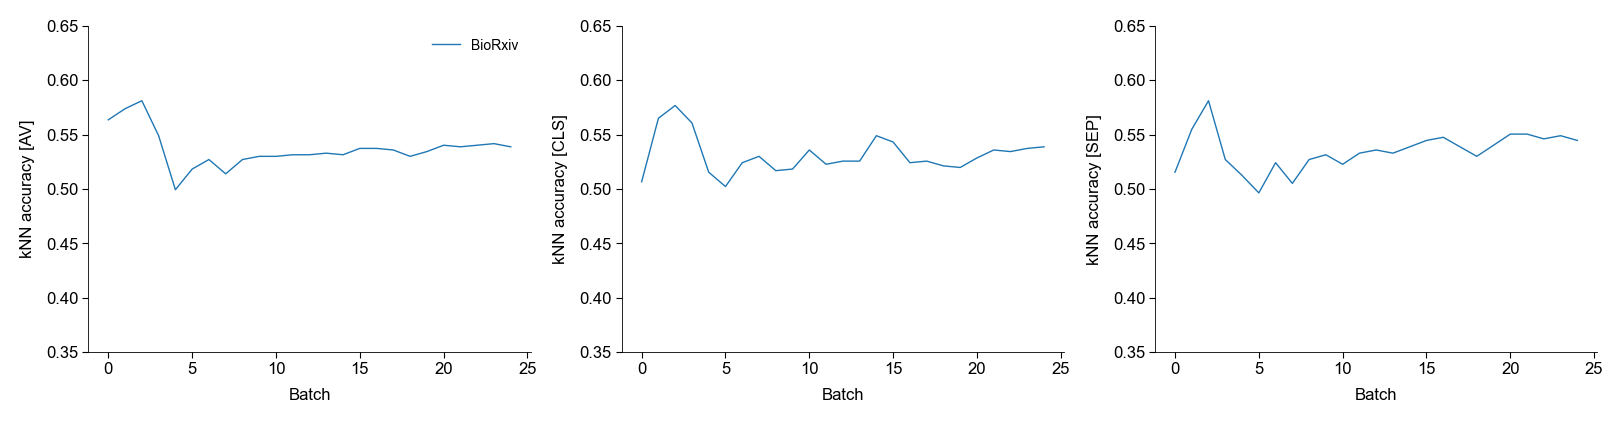

In [96]:
%matplotlib inline
n_epochs = 2
i = 0
model_name = model_names[0]

fig, ax = plt.subplots(1, 3, figsize=(8, 2), dpi=200)

# load
# saving_name_2 = Path("knn_accuracy_" + "bert" + ".npy")  -- THEY ARE NOT COMPUTED FOR PUBMED
# knn_acc_highd = np.load(variables_path / saving_name_2)

saving_path = Path("embeddings_" + model_name.lower())
(variables_path / saving_path).mkdir(exist_ok=True)

# losses_pubmed = np.load(
#     variables_path / saving_path / "losses_batches_train_pubmed_eval_pubmed_v1.npy",
# )
knn_accuracies_pubmed = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_biorxiv_eval_biorxiv_v1.npy",
)


ax[0].plot(
    np.arange(25), np.vstack(knn_accuracies_pubmed)[:, 0], label="BioRxiv"
)
# ax[0].scatter(-1, knn_acc_highd[0], c="tab:blue", s=5)
ax[0].set_ylim(0.35, 0.65)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy [AV]")
ax[0].legend()

ax[1].plot(
    np.arange(25), np.vstack(knn_accuracies_pubmed)[:, 1], label="BioRxiv"
)
# ax[1].scatter(-1, knn_acc_highd[1], c="tab:blue", s=5)
ax[1].set_ylim(0.35, 0.65)
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("kNN accuracy [CLS]")

ax[2].plot(
    np.arange(25), np.vstack(knn_accuracies_pubmed)[:, 2], label="BioRxiv"
)
# ax[2].scatter(-1, knn_acc_highd[2], c="tab:blue", s=5)
ax[2].set_ylim(0.35, 0.65)
ax[2].set_xlabel("Batch")
ax[2].set_ylabel("kNN accuracy [SEP]")

fig.savefig(
    figures_path
    / "knn_accuracies_bert_batches_train_biorxiv_eval_biorxiv_v1.png"
)

(1, 249)
(1, 234)


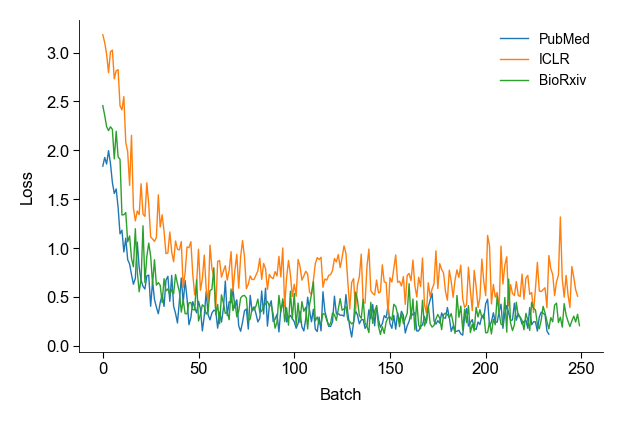

In [149]:
%matplotlib inline
n_epochs = 2
i = 0
model_name = model_names[0]

fig, ax = plt.subplots(figsize=(3, 2), dpi=200)

# load
# saving_name_2 = Path("knn_accuracy_" + "bert" + ".npy")  -- THEY ARE NOT COMPUTED FOR PUBMED
# knn_acc_highd = np.load(variables_path / saving_name_2)

saving_path = Path("embeddings_" + model_name.lower())
(variables_path / saving_path).mkdir(exist_ok=True)

losses_pubmed = np.load(
    variables_path
    / saving_path
    / "losses_batches_train_pubmed_eval_pubmed_v1.npy",
)
losses_iclr = np.load(
    variables_path
    / saving_path
    / "losses_batches_train_iclr_eval_iclr_v1.npy",
)
losses_biorxiv = np.load(
    variables_path
    / saving_path
    / "losses_batches_train_biorxiv_eval_biorxiv_v1.npy",
)

print(losses_iclr.shape)
print(losses_pubmed.shape)

ax.plot(
    np.arange(234),
    losses_pubmed.reshape(
        -1,
    ),
    label="PubMed",
)
ax.plot(
    np.arange(249),
    losses_iclr.reshape(
        -1,
    ),
    label="ICLR",
)
ax.plot(
    np.arange(250),
    losses_biorxiv.reshape(
        -1,
    ),
    label="BioRxiv",
)
# ax[0].scatter(-1, knn_acc_highd[0], c="tab:blue", s=5)
# ax.set_ylim(0.35, 0.65)
ax.set_xlabel("Batch")
ax.set_ylabel("Loss")
ax.legend()

# ax[1].plot(
#     np.arange(25), np.vstack(knn_accuracies_pubmed)[:, 1], label="BioRxiv"
# )
# # ax[1].scatter(-1, knn_acc_highd[1], c="tab:blue", s=5)
# ax[1].set_ylim(0.35, 0.65)
# ax[1].set_xlabel("Batch")
# ax[1].set_ylabel("kNN accuracy [CLS]")

# ax[2].plot(
#     np.arange(25), np.vstack(knn_accuracies_pubmed)[:, 2], label="BioRxiv"
# )
# # ax[2].scatter(-1, knn_acc_highd[2], c="tab:blue", s=5)
# ax[2].set_ylim(0.35, 0.65)
# ax[2].set_xlabel("Batch")
# ax[2].set_ylabel("kNN accuracy [SEP]")

# fig.savefig(
#     figures_path
#     / "knn_accuracies_bert_batches_train_biorxiv_eval_biorxiv_v1.png"
# )

In [108]:
print(700 / 16000 * 100)
print(700 / 75000 * 100)

4.375
0.9333333333333335
